<h1><center>CAN A COMPUTER RECOGNIZE SIGN LANGUAGE?</h1></center>

# Experimental Write-Up

## Project Problem and Hypothesis

BACKGROUND:  Sign language is a language that uses hand motions to represent a word or concept.  Sign language is not easily understood by hearing people with no background in sign language.  If there were a way to translate sign language motions into English, this would greatly increase the ability of the hearing and hard-of-hearing to understand each other.

OBJECTIVE:  Can we use motion sensor data to translate signs in Australian sign language into written English?

HYPOTHESIS:  Given motion sensor data, a machine learning algorithm can distinguish between the six question words:  
   what, when, where, which, who, why (classification problem).

SUCCESS METRIC:  Confusion matrix (precision and recall) for correct classification of six question words.  The optimal Area Under Curve (AUC) = 1.


## Dataset Description

DATA SOURCE:  https://archive.ics.uci.edu/ml/machine-learning-databases/auslan2-mld/auslan.data.html

DESCRIPTION:
  * 2565 signs: 27 samples of 95 signs made by 5 different signers
      * Note that although 95 different signs were available, we limited to the 6 question words for simplicity
  * Motion captured using Flock system
      * origin is a point just below the chin
      * x = number of meters in x-direction from origin 
      * y = number of meters in y-direction from origin
      * z = number of meters in z-direction from origin
      * Roll = number of degrees of palm rotation
          * 0 means palm is flat horizontal from perspective of the signer
          * -0.5 <= roll <= 0.5
          * positive means wrist is rolled clockwise from the perspective of the signer
          * multiply by 180 to get degrees
      * Pitch
          * 0 means palm is flat horizontal from the perspective of the signer
          * -0.5 <= pitch <= 0.5
          * positive means fingers are pointing up, palm facing out
          * multiply by 180 to get degrees      
      * Yaw
          * 0 means palm is flat horizontal from the perspective of the signer
          * -1.0 <= pitch <= 1.0
          * positive means wrist is cocked to the right 
          * multiply by 180 to get degrees            
      * Finger bend for 5 fingers
          * for each finger
              * 0 means straight finger
              * 1 means totally curled
              * 0 <= bend <= 1
              * bend measurements are not very exact
  * Avg Frames per sign:  41-102 (ave: 57)
      * Note that we limit to 51-52 frames per sign below to simplify the classification problem


<img src="PitchRollYaw.png">

<center><h3>Diagram of Roll, Pitch, and Yaw</h3></center> 

Think of the fingers of the hand as being the nose of the plane and the palm of the hand as being the belly of the plane.  This is the origin for roll, pitch, and yaw.

## Domain Knowledge

I have some background in American Sign Language (ASL), because my daughter did not initially speak when we adopted her at age 2. So we learned and taught her some ASL in order to communicate with my daughter for the first year.

This dataset was used by Mohammed Waleed Kadous as the basis of his doctoral dissertation at the University of New South Wales.  
* Summary of his work:  https://pdfs.semanticscholar.org/80d6/54eb9a924eb22d8cd6d72c45f2672cab7c75.pdf
* Dissertation:  Kadous, M. W., "Temporal Classification: Extending the Classification
Paradigm to Multivariate Time Series", PhD Thesis (draft), School of
Computer Science and Engineering, University of New South Wales, 2002.


## Project Concerns

The biggest obstacles to this sign language translation problem include:

1.  Wide range of number of frames for a given sign    
   The wide range of number of frames for a given sign is a result of each signer taking different amounts of time to make a given sign.  We have overcome this obstacle in a very restrictive way:  by limiting the dataset to those signs that require exactly 51 or 52 frames per sign, and by repeating the 51st frame for those signs with exactly 51 frames per sign.  In reality, it is not possible to force signers to stick to the same number of frames per sign, but when signing quickly, signers will have smaller number of frames per sign.

2.  Large number of signs    
   This dataset is relatively robust and includes 95 different signs.  We have overcome this obstacle by restricting the number of signs in our sample to 6 question words:  what, when, where, which, who, and why.  In reality, there are tens of thousands of signs in Australian Sign Language (Auslan), so the ability to classify motion sensor data into one of these over 10,000 signs is a much more difficult project.

3.  Relatively large number of features    
   This dataset has a relatively large number of features (11) relative to the number of signs to classify (6).     
   However, the data have some problems.  Firstly, for a given sign, the pinky and ring finger data appear to be exactly the same, so one or both of these incorrect, making these two features impossible to use for classification.  Secondly, The pitch and yaw data are always 0.  Thirdly, more generally, for a given sign, the remaining finger bend data have wide variations, making it difficult to classify into a single sign.  Therefore, the main features that can be used for classification purposes are:  x, y, z, and roll.  We will need to define some feature characteristics that will add to our feature set.

4.  Time series classification    
    Each sign constitutes 52 data points for each feature.  Classification in this case is classification of a curve to some "canonical" curve, for each feature.  One might be able to do this directly, or through the use of feature characteristics, e.g., the max value of x or the number of frames between the max and min values of x.  Some of the values have a wide variation in curves, suggesting that no such "canonical" curve exists, but curve characteristics may be possible to extract, e.g., two local maxima and two local minima.

In terms of risks to the project success, the risks of not correctly classifying a sign are not catastrophic from a harm point of view, but the goal of the project is to correctly classify signs.

## Potential Classification Methodologies

* K-nearest neighbor
    * Too many features to be effective (11 features)
* Random forest
* Support vector machine
* Hierarchical clustering of time series   
   https://stackoverflow.com/questions/34940808/hierarchical-clustering-of-time-series-in-python-scipy-numpy-pandas
* Feature Analysis for Time Series (FATS)  
https://pypi.python.org/pypi/FATS/1.3.6
* Extract relevant characteristics from each feature, e.g., average value of time series, distribution of values, lag between min and max, rolling window statistics.  Then use traditional classification techniques using these additional features
* Ensembling of best methods above for each feature

## Outcomes

I am expecting that given the motion sensor data for one of our six question words, we would be able to identify which question word it is.

If the classifier is able to identify the sign over 80% of the time, I would consider the project a success.  The most important feature is likely the z or roll.  Both z and roll appear to be able to distinguish between several signs upon visual inspection.

Some potential ways to improve the model would be:
* add more features in the form of feature characteristics, e.g., two local maxima
* use some or all of the techniques desribed as potential classification methodologies.  

# Exploratory Data Analysis

In [1]:
import os
import fnmatch

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)

  # PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

  #for Widget
from IPython.display import display
from ipywidgets import interactive, Select, Output, widgets

import seaborn as sns

In [2]:
   # this function reads in one datafile at a time
def read_in_file(person, session_num, sign, test_num):
    df = pd.read_csv(os.path.join('..', '..', '..', 'DS-SF-34-MyStuff', 'Australian-Sign-Language',
                                  'signs', person+session_num, sign+test_num+'.sign'), header=None)
    df.rename(columns = {0: 'x',
    1: 'y',
    2: 'z',
    3: 'roll',
    4: 'pitch',
    5: 'yaw',
    6: 'thumb_bend',
    7: 'pointer_bend',
    8: 'middle_bend',
    9: 'ring_bend',
    10: 'pinky_bend'}, inplace = True)
    df['signer'] = person
    df['sign'] = sign
    df['session'] = session_num
    df['test'] = test_num
    df['signr_sess_test']=person+session_num+test_num
    df['sign_index']=range(1, len(df) + 1)
    return df

   # this function cleans up the dataframe by adding a field called "num_frames"
def add_num_frames(sign_name):    
    sign_name['num_frames'] = sign_name.groupby(['signr_sess_test'])['x'].transform('count').astype(int)
    return sign_name


## WHAT

In [26]:
def get_what():
    file_1=read_in_file('adam','1','what','0')
    file_2=read_in_file('adam','1','what','1')
    file_3=read_in_file('adam','2','what','0')
    file_4=read_in_file('adam','2','what','1')
    file_5=read_in_file('adam','2','what','2')
    file_6=read_in_file('adam','2','what','3')
    file_7=read_in_file('adam','2','what','4')
    file_8=read_in_file('adam','2','what','5')
    file_9=read_in_file('andrew','1','what','0')
    file_10=read_in_file('andrew','2','what','1')
    file_11=read_in_file('andrew','2','what','2')
    file_12=read_in_file('andrew','2','what','3')
    file_13=read_in_file('andrew','2','what','4')
    file_14=read_in_file('andrew','3','what','0')
    file_15=read_in_file('andrew','3','what','1')
    file_16=read_in_file('john','1','what','0')
    file_17=read_in_file('john','2','what','0')
    file_18=read_in_file('john','2','what','1')
    file_19=read_in_file('john','2','what','2')
    file_20=read_in_file('john','2','what','3')
    file_21=read_in_file('john','2','what','4')
    file_22=read_in_file('john','3','what','0')
    file_23=read_in_file('john','3','what','1')
    file_24=read_in_file('john','3','what','2')
    file_25=read_in_file('john','3','what','3')
    file_26=read_in_file('john','3','what','4')
    file_27=read_in_file('john','4','what','0')
    file_28=read_in_file('john','4','what','1')
    file_29=read_in_file('john','4','what','2')
    file_30=read_in_file('john','4','what','3')
    file_31=read_in_file('john','4','what','4')  
    file_32=read_in_file('john','4','what','4')
    file_33=read_in_file('john','5','what','0')
    file_34=read_in_file('john','5','what','1')
    file_35=read_in_file('stephen','1','what','0')
    file_36=read_in_file('stephen','2','what','1')
    file_37=read_in_file('stephen','2','what','2')
    file_38=read_in_file('stephen','2','what','3')
    file_39=read_in_file('stephen','2','what','4')
    file_40=read_in_file('stephen','3','what','0')
    file_41=read_in_file('stephen','3','what','1')
    file_42=read_in_file('stephen','3','what','2')
    file_43=read_in_file('stephen','3','what','3')
    file_44=read_in_file('stephen','3','what','4')
    file_45=read_in_file('stephen','4','what','0')
    file_46=read_in_file('stephen','4','what','1')
    file_47=read_in_file('stephen','4','what','2')
    file_48=read_in_file('stephen','4','what','3')
    file_49=read_in_file('stephen','4','what','4')
    file_50=read_in_file('waleed','1','what','0')
    file_51=read_in_file('waleed','1','what','1')
    file_52=read_in_file('waleed','1','what','2')
    file_53=read_in_file('waleed','1','what','3')
    file_54=read_in_file('waleed','1','what','4')
    file_55=read_in_file('waleed','2','what','0')
    file_56=read_in_file('waleed','2','what','1')
    file_57=read_in_file('waleed','2','what','2')
    file_58=read_in_file('waleed','2','what','3')
    file_59=read_in_file('waleed','2','what','4')
    file_60=read_in_file('waleed','3','what','0')
    file_61=read_in_file('waleed','3','what','1')
    file_62=read_in_file('waleed','3','what','2')
    file_63=read_in_file('waleed','3','what','3')
    file_64=read_in_file('waleed','3','what','4')
    file_65=read_in_file('waleed','4','what','0')
    file_66=read_in_file('waleed','4','what','1')
    file_67=read_in_file('waleed','4','what','2')
    file_68=read_in_file('waleed','4','what','3')
    file_69=read_in_file('waleed','4','what','4')
    what=pd.concat([file_1,file_2,file_3,file_4,file_5,file_6,file_7,file_8,file_9,file_10,
                 file_11,file_12,file_13,file_14,file_15,file_16,file_17,file_18,file_19,file_10,
                 file_21,file_22,file_23,file_24,file_25,file_26,file_27,file_28,file_29,file_20,
                 file_31,file_32,file_33,file_34,file_35,file_36,file_37,file_38,file_39,file_30,
                 file_41,file_42,file_43,file_44,file_45,file_46,file_47,file_48,file_49,file_40,
                 file_51,file_52,file_53,file_54,file_55,file_56,file_57,file_58,file_59,file_50,
                 file_61,file_62,file_63,file_64,file_65,file_66,file_67,file_68,file_69])

    return what

what=get_what()
add_num_frames(what)
    # how many frames do we have for each "what" sign?  It varies quite a bit.
what[['signr_sess_test','x']].groupby(['signr_sess_test'])['x'].count()


signr_sess_test
adam10        49
adam11        54
adam20        46
adam21        50
adam22        51
adam23        42
adam24        50
adam25        50
andrew10      93
andrew21     102
andrew22      69
andrew23      55
andrew24      56
andrew30      48
andrew31      45
john10        66
john20        63
john21        64
john22        63
john23        63
john24        66
john30        53
john31        48
john32        51
john33        49
john34        55
john40        50
john41        49
john42        53
john43        54
john44        96
john50        55
john51        59
stephen10     68
stephen21     60
stephen22     58
stephen23     57
stephen24     57
stephen30     78
stephen31     62
stephen32     71
stephen33     65
stephen34     65
stephen40     66
stephen41     71
stephen42     68
stephen43     68
stephen44     68
waleed10      49
waleed11      51
waleed12      48
waleed13      51
waleed14      49
waleed20      48
waleed21      46
waleed22      49
waleed23      48
waleed24      5

In [5]:
len(what)

3957

In [6]:
  # 41
#what.groupby(['signr_sess_test'])['x'].count().min()
  # 102
what.groupby(['signr_sess_test'])['x'].count().max()
  # 57.14
#what.groupby(['signr_sess_test'])['x'].count().mean()

93

In [7]:
   # create a table of frequencies to see how many num_frames we have
freq_what = what.groupby(['signr_sess_test'])['x'].count().value_counts().reset_index()
freq_what.columns = ['num_frames','count']
freq_what

,num_frames,count
0,49,6
1,48,6
2,68,5
3,51,5
4,65,4
5,50,4
6,66,3
7,55,3
8,63,3
9,46,3


## WHEN

In [8]:
   #  read in all of the files for WHEN
    # you have to do this manually for each sign, 
      # because each sign has a different # of session_# and test_#s from the dataset

def get_when():
    file_1=read_in_file('adam','1','when','0')
    file_2=read_in_file('adam','1','when','1')
    file_3=read_in_file('adam','2','when','0')
    file_4=read_in_file('adam','2','when','1')
    file_5=read_in_file('adam','2','when','2')
    file_6=read_in_file('adam','2','when','3')
    file_7=read_in_file('adam','2','when','4')
    file_8=read_in_file('adam','2','when','5')
    file_9=read_in_file('andrew','1','when','0')
    file_10=read_in_file('andrew','2','when','1')
    file_11=read_in_file('andrew','2','when','2')
    file_12=read_in_file('andrew','2','when','3')
    file_13=read_in_file('andrew','2','when','4')
    file_14=read_in_file('andrew','3','when','0')
    file_15=read_in_file('andrew','3','when','1')
    file_16=read_in_file('john','1','when','0')
    file_17=read_in_file('john','2','when','0')
    file_18=read_in_file('john','2','when','1')
    file_19=read_in_file('john','2','when','2')
    file_20=read_in_file('john','2','when','3')
    file_21=read_in_file('john','2','when','4')
    file_22=read_in_file('john','3','when','0')
    file_23=read_in_file('john','3','when','1')
    file_24=read_in_file('john','3','when','2')
    file_25=read_in_file('john','3','when','3')
    file_26=read_in_file('john','3','when','4')
    file_27=read_in_file('john','4','when','0')
    file_28=read_in_file('john','4','when','1')
    file_29=read_in_file('john','4','when','2')
    file_30=read_in_file('john','4','when','3')
    file_31=read_in_file('john','4','when','4')
    file_32=read_in_file('john','5','when','0')
    file_33=read_in_file('john','5','when','1')
    file_34=read_in_file('stephen','1','when','0')
    file_35=read_in_file('stephen','2','when','1')
    file_36=read_in_file('stephen','2','when','2')
    file_37=read_in_file('stephen','2','when','3')
    file_38=read_in_file('stephen','2','when','4')
    file_39=read_in_file('stephen','3','when','0')
    file_40=read_in_file('stephen','3','when','1')
    file_41=read_in_file('stephen','3','when','2')
    file_42=read_in_file('stephen','3','when','3')
    file_68=read_in_file('stephen','3','when','4')
    file_43=read_in_file('stephen','4','when','0')
    file_44=read_in_file('stephen','4','when','1')
    file_45=read_in_file('stephen','4','when','2')
    file_46=read_in_file('stephen','4','when','3')
    file_47=read_in_file('stephen','4','when','4')
    file_48=read_in_file('waleed','1','when','0')
    file_49=read_in_file('waleed','1','when','1')
    file_50=read_in_file('waleed','1','when','2')
    file_51=read_in_file('waleed','1','when','3')
    file_52=read_in_file('waleed','1','when','4')
    file_53=read_in_file('waleed','2','when','0')
    file_54=read_in_file('waleed','2','when','1')
    file_55=read_in_file('waleed','2','when','2')
    file_56=read_in_file('waleed','2','when','3')
    file_57=read_in_file('waleed','2','when','4')
    file_58=read_in_file('waleed','3','when','0')
    file_59=read_in_file('waleed','3','when','1')
    file_60=read_in_file('waleed','3','when','2')
    file_61=read_in_file('waleed','3','when','3')
    file_62=read_in_file('waleed','3','when','4')
    file_63=read_in_file('waleed','4','when','0')
    file_64=read_in_file('waleed','4','when','1')
    file_65=read_in_file('waleed','4','when','2')
    file_66=read_in_file('waleed','4','when','3')
    file_67=read_in_file('waleed','4','when','4')
    when=pd.concat([file_1,file_2,file_3,file_4,file_5,file_6,file_7,file_8,file_9,file_10,
                 file_11,file_12,file_13,file_14,file_15,file_16,file_17,file_18,file_19,file_10,
                 file_21,file_22,file_23,file_24,file_25,file_26,file_27,file_28,file_29,file_20,
                 file_31,file_32,file_33,file_34,file_35,file_36,file_37,file_38,file_39,file_30,
                 file_41,file_42,file_43,file_44,file_45,file_46,file_47,file_48,file_49,file_40,
                 file_51,file_52,file_53,file_54,file_55,file_56,file_57,file_58,file_59,file_50,
                 file_61,file_62,file_63,file_64,file_65,file_66,file_67,file_68])

    return when

when=get_when()
add_num_frames(when)

    # how many frames do we have for each "when" sign?  It varies quite a bit.
when[['signr_sess_test','x']].groupby(['signr_sess_test'])['x'].count()


signr_sess_test
adam10        55
adam11        56
adam20        41
adam21        48
adam22        47
adam23        49
adam24        59
adam25        58
andrew10      98
andrew21     292
andrew22      58
andrew23      62
andrew24      58
andrew30      68
andrew31      48
john10        69
john20        62
john21        71
john22        79
john23        72
john24        67
john30        55
john31        49
john32        66
john33        52
john34        56
john40        48
john41        56
john42        58
john43        58
john44        50
john50        48
john51        48
stephen10    109
stephen21     55
stephen22     49
stephen23     57
stephen24     59
stephen30     79
stephen31     69
stephen32     78
stephen33     70
stephen34     71
stephen40     61
stephen41     58
stephen42     51
stephen43     64
stephen44     66
waleed10      53
waleed11      60
waleed12      60
waleed13      55
waleed14      52
waleed20      52
waleed21      57
waleed22      52
waleed23      55
waleed24      4

In [9]:
  # 41
#when.groupby(['signr_sess_test'])['x'].count().min()
  # 292
when.groupby(['signr_sess_test'])['x'].count().max()
  # 63.2
#when.groupby(['signr_sess_test'])['x'].count().mean()

292

In [10]:
   # create a table of frequencies to see how many num_frames we have
freq_when = when.groupby(['signr_sess_test'])['x'].count().value_counts().reset_index()
freq_when.columns = ['num_frames','count']
freq_when

,num_frames,count
0,58,7
1,55,5
2,48,5
3,60,4
4,56,4
5,57,4
6,52,4
7,49,3
8,64,2
9,59,2


## WHERE

In [11]:
   #  read in all of the files for where
    # you have to do this manually for each sign, 
      # because each sign has a different # of session_# and test_#s from the dataset

def get_where():
    file_1=read_in_file('adam','1','where','0')
    file_2=read_in_file('adam','1','where','1')
    file_3=read_in_file('adam','2','where','0')
    file_4=read_in_file('adam','2','where','1')
    file_5=read_in_file('adam','2','where','2')
    file_6=read_in_file('adam','2','where','3')
    file_7=read_in_file('adam','2','where','4')
    file_8=read_in_file('adam','2','where','5')
    file_9=read_in_file('andrew','1','where','0')
    file_10=read_in_file('andrew','2','where','1')
    file_11=read_in_file('andrew','2','where','2')
    file_12=read_in_file('andrew','2','where','3')
    file_13=read_in_file('andrew','2','where','4')
    file_14=read_in_file('andrew','3','where','0')
    file_15=read_in_file('andrew','3','where','1')
    file_16=read_in_file('john','1','where','0')
    file_17=read_in_file('john','2','where','0')
    file_18=read_in_file('john','2','where','1')
    file_19=read_in_file('john','2','where','2')
    file_20=read_in_file('john','2','where','3')
    file_21=read_in_file('john','2','where','4')
    file_22=read_in_file('john','3','where','0')
    file_23=read_in_file('john','3','where','1')
    file_24=read_in_file('john','3','where','2')
    file_25=read_in_file('john','3','where','3')
    file_26=read_in_file('john','3','where','4')
    file_27=read_in_file('john','4','where','0')
    file_28=read_in_file('john','4','where','1')
    file_29=read_in_file('john','4','where','2')
    file_30=read_in_file('john','4','where','3')
    file_31=read_in_file('john','4','where','4')
    file_32=read_in_file('john','5','where','0')
    file_33=read_in_file('john','5','where','1')
    file_34=read_in_file('stephen','1','where','0')
    file_35=read_in_file('stephen','2','where','1')
    file_36=read_in_file('stephen','2','where','2')
    file_37=read_in_file('stephen','2','where','3')
    file_38=read_in_file('stephen','2','where','4')
    file_39=read_in_file('stephen','3','where','0')
    file_40=read_in_file('stephen','3','where','1')
    file_41=read_in_file('stephen','3','where','2')
    file_42=read_in_file('stephen','3','where','3')
    file_68=read_in_file('stephen','3','where','4')
    file_43=read_in_file('stephen','4','where','0')
    file_44=read_in_file('stephen','4','where','1')
    file_45=read_in_file('stephen','4','where','2')
    file_46=read_in_file('stephen','4','where','3')
    file_47=read_in_file('stephen','4','where','4')
    file_48=read_in_file('waleed','1','where','0')
    file_49=read_in_file('waleed','1','where','1')
    file_50=read_in_file('waleed','1','where','2')
    file_51=read_in_file('waleed','1','where','3')
    file_52=read_in_file('waleed','1','where','4')
    file_53=read_in_file('waleed','2','where','0')
    file_54=read_in_file('waleed','2','where','1')
    file_55=read_in_file('waleed','2','where','2')
    file_56=read_in_file('waleed','2','where','3')
    file_57=read_in_file('waleed','2','where','4')
    file_58=read_in_file('waleed','3','where','0')
    file_59=read_in_file('waleed','3','where','1')
    file_60=read_in_file('waleed','3','where','2')
    file_61=read_in_file('waleed','3','where','3')
    file_62=read_in_file('waleed','3','where','4')
    file_63=read_in_file('waleed','4','where','0')
    file_64=read_in_file('waleed','4','where','1')
    file_65=read_in_file('waleed','4','where','2')
    file_66=read_in_file('waleed','4','where','3')
    file_67=read_in_file('waleed','4','where','4')
    where=pd.concat([file_1,file_2,file_3,file_4,file_5,file_6,file_7,file_8,file_9,file_10,
                 file_11,file_12,file_13,file_14,file_15,file_16,file_17,file_18,file_19,file_10,
                 file_21,file_22,file_23,file_24,file_25,file_26,file_27,file_28,file_29,file_20,
                 file_31,file_32,file_33,file_34,file_35,file_36,file_37,file_38,file_39,file_30,
                 file_41,file_42,file_43,file_44,file_45,file_46,file_47,file_48,file_49,file_40,
                 file_51,file_52,file_53,file_54,file_55,file_56,file_57,file_58,file_59,file_50,
                 file_61,file_62,file_63,file_64,file_65,file_66,file_67,file_68])

    return where

where=get_where()
add_num_frames(where)

    # how many frames do we have for each "where" sign?  It varies quite a bit.
where[['signr_sess_test','x']].groupby(['signr_sess_test'])['x'].count()


signr_sess_test
adam10        53
adam11        50
adam20        46
adam21        49
adam22        47
adam23        50
adam24        51
adam25        47
andrew10      92
andrew21     128
andrew22      64
andrew23     109
andrew24     169
andrew30      55
andrew31      45
john10       485
john20        81
john21        77
john22        72
john23        79
john24        73
john30        50
john31        54
john32        58
john33        56
john34        51
john40        52
john41        55
john42        53
john43        54
john44        53
john50        49
john51        53
stephen10     68
stephen21     58
stephen22     54
stephen23     61
stephen24     53
stephen30     85
stephen31     78
stephen32     74
stephen33     76
stephen34     68
stephen40     69
stephen41     64
stephen42     62
stephen43     66
stephen44     61
waleed10      47
waleed11      51
waleed12      55
waleed13      52
waleed14      59
waleed20      47
waleed21      53
waleed22      49
waleed23      52
waleed24      5

In [12]:
  # 45
#where.groupby(['signr_sess_test'])['x'].count().min()
  # 485
where.groupby(['signr_sess_test'])['x'].count().max()
  # 68.06
#where.groupby(['signr_sess_test'])['x'].count().mean()

485

In [13]:
   # create a table of frequencies to see how many num_frames we have
freq_where = where.groupby(['signr_sess_test'])['x'].count().value_counts().reset_index()
freq_where.columns = ['num_frames','count']
freq_where

,num_frames,count
0,53,8
1,55,5
2,50,5
3,52,4
4,47,4
5,54,4
6,49,3
7,51,3
8,58,2
9,64,2


##  WHICH

In [14]:
   #  read in all of the files for which
    # you have to do this manually for each sign, 
      # because each sign has a different # of session_# and test_#s from the dataset

def get_which():
    file_1=read_in_file('adam','1','which','0')
    file_2=read_in_file('adam','1','which','1')
    file_3=read_in_file('adam','2','which','0')
    file_4=read_in_file('adam','2','which','1')
    file_5=read_in_file('adam','2','which','2')
    file_6=read_in_file('adam','2','which','3')
    file_7=read_in_file('adam','2','which','4')
    file_8=read_in_file('adam','2','which','5')
    file_9=read_in_file('andrew','1','which','0')
    file_10=read_in_file('andrew','2','which','1')
    file_11=read_in_file('andrew','2','which','2')
    file_12=read_in_file('andrew','2','which','3')
    file_13=read_in_file('andrew','2','which','4')
    file_14=read_in_file('andrew','3','which','0')
    file_15=read_in_file('andrew','3','which','1')
    file_16=read_in_file('john','1','which','0')
    file_17=read_in_file('john','2','which','0')
    file_18=read_in_file('john','2','which','1')
    file_19=read_in_file('john','2','which','2')
    file_20=read_in_file('john','2','which','3')
    file_21=read_in_file('john','2','which','4')
    file_22=read_in_file('john','3','which','0')
    file_23=read_in_file('john','3','which','1')
    file_24=read_in_file('john','3','which','2')
    file_25=read_in_file('john','3','which','3')
    file_26=read_in_file('john','3','which','4')
    file_27=read_in_file('john','4','which','0')
    file_28=read_in_file('john','4','which','1')
    file_29=read_in_file('john','4','which','2')
    file_30=read_in_file('john','4','which','3')
    file_31=read_in_file('john','4','which','4')
    file_32=read_in_file('john','5','which','0')
    file_33=read_in_file('john','5','which','1')
    file_34=read_in_file('stephen','1','which','0')
    file_35=read_in_file('stephen','2','which','1')
    file_36=read_in_file('stephen','2','which','2')
    file_37=read_in_file('stephen','2','which','3')
    file_38=read_in_file('stephen','2','which','4')
    file_39=read_in_file('stephen','3','which','0')
    file_40=read_in_file('stephen','3','which','1')
    file_41=read_in_file('stephen','3','which','2')
    file_42=read_in_file('stephen','3','which','3')
    file_68=read_in_file('stephen','3','which','4')
    file_43=read_in_file('stephen','4','which','0')
    file_44=read_in_file('stephen','4','which','1')
    file_45=read_in_file('stephen','4','which','2')
    file_46=read_in_file('stephen','4','which','3')
    file_47=read_in_file('stephen','4','which','4')
    file_48=read_in_file('waleed','1','which','0')
    file_49=read_in_file('waleed','1','which','1')
    file_50=read_in_file('waleed','1','which','2')
    file_51=read_in_file('waleed','1','which','3')
    file_52=read_in_file('waleed','1','which','4')
    file_53=read_in_file('waleed','2','which','0')
    file_54=read_in_file('waleed','2','which','1')
    file_55=read_in_file('waleed','2','which','2')
    file_56=read_in_file('waleed','2','which','3')
    file_57=read_in_file('waleed','2','which','4')
    file_58=read_in_file('waleed','3','which','0')
    file_59=read_in_file('waleed','3','which','1')
    file_60=read_in_file('waleed','3','which','2')
    file_61=read_in_file('waleed','3','which','3')
    file_62=read_in_file('waleed','3','which','4')
    file_63=read_in_file('waleed','4','which','0')
    file_64=read_in_file('waleed','4','which','1')
    file_65=read_in_file('waleed','4','which','2')
    file_66=read_in_file('waleed','4','which','3')
    file_67=read_in_file('waleed','4','which','4')
    which=pd.concat([file_1,file_2,file_3,file_4,file_5,file_6,file_7,file_8,file_9,file_10,
                 file_11,file_12,file_13,file_14,file_15,file_16,file_17,file_18,file_19,file_10,
                 file_21,file_22,file_23,file_24,file_25,file_26,file_27,file_28,file_29,file_20,
                 file_31,file_32,file_33,file_34,file_35,file_36,file_37,file_38,file_39,file_30,
                 file_41,file_42,file_43,file_44,file_45,file_46,file_47,file_48,file_49,file_40,
                 file_51,file_52,file_53,file_54,file_55,file_56,file_57,file_58,file_59,file_50,
                 file_61,file_62,file_63,file_64,file_65,file_66,file_67,file_68])

    return which

which=get_which()
add_num_frames(which)

    # how many frames do we have for each "which" sign?  It varies quite a bit.
which[['signr_sess_test','x']].groupby(['signr_sess_test'])['x'].count()


signr_sess_test
adam10        58
adam11        51
adam20        47
adam21        47
adam22        47
adam23        48
adam24        43
adam25        47
andrew10     121
andrew21     112
andrew22      49
andrew23      52
andrew24      55
andrew30      49
andrew31      45
john10        75
john20        64
john21        74
john22        64
john23        59
john24        59
john30        51
john31        47
john32        52
john33        52
john34        47
john40        60
john41        54
john42        60
john43        56
john44        53
john50        57
john51        50
stephen10    101
stephen21     68
stephen22     64
stephen23     65
stephen24     68
stephen30     65
stephen31     54
stephen32     59
stephen33     63
stephen34     57
stephen40     68
stephen41     69
stephen42     65
stephen43     63
stephen44     68
waleed10      77
waleed11      58
waleed12      63
waleed13      53
waleed14      56
waleed20      67
waleed21      52
waleed22      56
waleed23      44
waleed24      4

In [15]:
  #  43
#which.groupby(['signr_sess_test'])['x'].count().min()
  # 121
which.groupby(['signr_sess_test'])['x'].count().max()
  # 58.8
#which.groupby(['signr_sess_test'])['x'].count().mean()

121

In [16]:
   # create a table of frequencies to see how many num_frames we have
freq_which = which.groupby(['signr_sess_test'])['x'].count().value_counts().reset_index()
freq_which.columns = ['num_frames','count']
freq_which

,num_frames,count
0,47,6
1,52,5
2,68,4
3,59,3
4,64,3
5,50,3
6,51,3
7,53,3
8,56,3
9,63,3


## WHO

In [17]:
   #  read in all of the files for who
    # you have to do this manually for each sign, 
      # because each sign has a different # of session_# and test_#s from the dataset

def get_who():
    file_1=read_in_file('adam','1','who','0')
    file_2=read_in_file('adam','1','who','1')
    file_3=read_in_file('adam','2','who','0')
    file_4=read_in_file('adam','2','who','1')
    file_5=read_in_file('adam','2','who','2')
    file_6=read_in_file('adam','2','who','3')
    file_7=read_in_file('adam','2','who','4')
    file_8=read_in_file('adam','2','who','5')
    file_9=read_in_file('andrew','1','who','0')
    file_10=read_in_file('andrew','2','who','1')
    file_11=read_in_file('andrew','2','who','2')
    file_12=read_in_file('andrew','2','who','3')
    file_13=read_in_file('andrew','2','who','4')
    file_14=read_in_file('andrew','3','who','0')
    file_15=read_in_file('andrew','3','who','1')
    file_16=read_in_file('john','1','who','0')
    file_17=read_in_file('john','2','who','0')
    file_18=read_in_file('john','2','who','1')
    file_19=read_in_file('john','2','who','2')
    file_20=read_in_file('john','2','who','3')
    file_21=read_in_file('john','2','who','4')
    file_22=read_in_file('john','3','who','0')
    file_23=read_in_file('john','3','who','1')
    file_24=read_in_file('john','3','who','2')
    file_25=read_in_file('john','3','who','3')
    file_26=read_in_file('john','3','who','4')
    file_27=read_in_file('john','4','who','0')
    file_28=read_in_file('john','4','who','1')
    file_29=read_in_file('john','4','who','2')
    file_30=read_in_file('john','4','who','3')
    file_31=read_in_file('john','4','who','4')
    file_32=read_in_file('john','5','who','0')
    file_33=read_in_file('john','5','who','1')
    file_34=read_in_file('stephen','1','who','0')
    file_35=read_in_file('stephen','2','who','1')
    file_36=read_in_file('stephen','2','who','2')
    file_37=read_in_file('stephen','2','who','3')
    file_38=read_in_file('stephen','2','who','4')
    file_39=read_in_file('stephen','3','who','0')
    file_40=read_in_file('stephen','3','who','1')
    file_41=read_in_file('stephen','3','who','2')
    file_42=read_in_file('stephen','3','who','3')
    file_68=read_in_file('stephen','3','who','4')
    file_43=read_in_file('stephen','4','who','0')
    file_44=read_in_file('stephen','4','who','1')
    file_45=read_in_file('stephen','4','who','2')
    file_46=read_in_file('stephen','4','who','3')
    file_47=read_in_file('stephen','4','who','4')
    file_48=read_in_file('waleed','1','who','0')
    file_49=read_in_file('waleed','1','who','1')
    file_50=read_in_file('waleed','1','who','2')
    file_51=read_in_file('waleed','1','who','3')
    file_52=read_in_file('waleed','1','who','4')
    file_53=read_in_file('waleed','2','who','0')
    file_54=read_in_file('waleed','2','who','1')
    file_55=read_in_file('waleed','2','who','2')
    file_56=read_in_file('waleed','2','who','3')
    file_57=read_in_file('waleed','2','who','4')
    file_58=read_in_file('waleed','3','who','0')
    file_59=read_in_file('waleed','3','who','1')
    file_60=read_in_file('waleed','3','who','2')
    file_61=read_in_file('waleed','3','who','3')
    file_62=read_in_file('waleed','3','who','4')
    file_63=read_in_file('waleed','4','who','0')
    file_64=read_in_file('waleed','4','who','1')
    file_65=read_in_file('waleed','4','who','2')
    file_66=read_in_file('waleed','4','who','3')
    file_67=read_in_file('waleed','4','who','4')
    who=pd.concat([file_1,file_2,file_3,file_4,file_5,file_6,file_7,file_8,file_9,file_10,
                 file_11,file_12,file_13,file_14,file_15,file_16,file_17,file_18,file_19,file_10,
                 file_21,file_22,file_23,file_24,file_25,file_26,file_27,file_28,file_29,file_20,
                 file_31,file_32,file_33,file_34,file_35,file_36,file_37,file_38,file_39,file_30,
                 file_41,file_42,file_43,file_44,file_45,file_46,file_47,file_48,file_49,file_40,
                 file_51,file_52,file_53,file_54,file_55,file_56,file_57,file_58,file_59,file_50,
                 file_61,file_62,file_63,file_64,file_65,file_66,file_67,file_68])

    return who

who=get_who()
add_num_frames(who)

    # how many frames do we have for each "who" sign?  It varies quite a bit.
who[['signr_sess_test','x']].groupby(['signr_sess_test'])['x'].count()


signr_sess_test
adam10        59
adam11        69
adam20        50
adam21        48
adam22        54
adam23        48
adam24        51
adam25        51
andrew10      97
andrew21     126
andrew22      98
andrew23      64
andrew24      65
andrew30      54
andrew31      49
john10       121
john20        68
john21        73
john22        65
john23        69
john24        70
john30        75
john31        70
john32        67
john33        64
john34        59
john40        73
john41        66
john42        69
john43        70
john44        68
john50        53
john51        62
stephen10    124
stephen21     70
stephen22     57
stephen23     64
stephen24     66
stephen30     66
stephen31     79
stephen32     75
stephen33     73
stephen34     73
stephen40     65
stephen41     73
stephen42     69
stephen43     73
stephen44     75
waleed10      51
waleed11      54
waleed12      57
waleed13      60
waleed14      51
waleed20      54
waleed21      55
waleed22      56
waleed23      62
waleed24      6

In [18]:
  # 48
#who.groupby(['signr_sess_test'])['x'].count().min()
  # 126
who.groupby(['signr_sess_test'])['x'].count().max()
  # 65.9
#who.groupby(['signr_sess_test'])['x'].count().mean()

126

In [19]:
   # create a table of frequencies to see how many num_frames we have
freq_who = who.groupby(['signr_sess_test'])['x'].count().value_counts().reset_index()
freq_who.columns = ['num_frames','count']
freq_who

,num_frames,count
0,54,6
1,73,6
2,70,5
3,51,4
4,69,4
5,64,3
6,66,3
7,53,3
8,59,3
9,65,3


## WHY

In [20]:
   #  read in all of the files for why
    # you have to do this manually for each sign, 
      # because each sign has a different # of session_# and test_#s from the dataset

def get_why():
    file_1=read_in_file('adam','1','why','0')
    file_2=read_in_file('adam','1','why','1')
    file_3=read_in_file('adam','2','why','0')
    file_4=read_in_file('adam','2','why','1')
    file_5=read_in_file('adam','2','why','2')
    file_6=read_in_file('adam','2','why','3')
    file_7=read_in_file('adam','2','why','4')
    file_8=read_in_file('adam','2','why','5')
    file_9=read_in_file('andrew','1','why','0')
    file_10=read_in_file('andrew','2','why','1')
    file_11=read_in_file('andrew','2','why','2')
    file_12=read_in_file('andrew','2','why','3')
    file_13=read_in_file('andrew','2','why','4')
    file_14=read_in_file('andrew','3','why','0')
    file_15=read_in_file('andrew','3','why','1')
    file_16=read_in_file('john','1','why','0')
    file_17=read_in_file('john','2','why','0')
    file_18=read_in_file('john','2','why','1')
    file_19=read_in_file('john','2','why','2')
    file_20=read_in_file('john','2','why','3')
    file_21=read_in_file('john','2','why','4')
    file_22=read_in_file('john','3','why','0')
    file_23=read_in_file('john','3','why','1')
    file_24=read_in_file('john','3','why','2')
    file_25=read_in_file('john','3','why','3')
    file_26=read_in_file('john','3','why','4')
    file_27=read_in_file('john','4','why','0')
    file_28=read_in_file('john','4','why','1')
    file_29=read_in_file('john','4','why','2')
    file_30=read_in_file('john','4','why','3')
    file_31=read_in_file('john','4','why','4')
    file_32=read_in_file('john','5','why','0')
    file_33=read_in_file('john','5','why','1')
    file_34=read_in_file('stephen','1','why','0')
    file_35=read_in_file('stephen','2','why','1')
    file_36=read_in_file('stephen','2','why','2')
    file_37=read_in_file('stephen','2','why','3')
    file_38=read_in_file('stephen','2','why','4')
    file_39=read_in_file('stephen','3','why','0')
    file_40=read_in_file('stephen','3','why','1')
    file_41=read_in_file('stephen','3','why','2')
    file_42=read_in_file('stephen','3','why','3')
    file_68=read_in_file('stephen','3','why','4')
    file_43=read_in_file('stephen','4','why','0')
    file_44=read_in_file('stephen','4','why','1')
    file_45=read_in_file('stephen','4','why','2')
    file_46=read_in_file('stephen','4','why','3')
    file_47=read_in_file('stephen','4','why','4')
    file_48=read_in_file('waleed','1','why','0')
    file_49=read_in_file('waleed','1','why','1')
    file_50=read_in_file('waleed','1','why','2')
    file_51=read_in_file('waleed','1','why','3')
    file_52=read_in_file('waleed','1','why','4')
    file_53=read_in_file('waleed','2','why','0')
    file_54=read_in_file('waleed','2','why','1')
    file_55=read_in_file('waleed','2','why','2')
    file_56=read_in_file('waleed','2','why','3')
    file_57=read_in_file('waleed','2','why','4')
    file_58=read_in_file('waleed','3','why','0')
    file_59=read_in_file('waleed','3','why','1')
    file_60=read_in_file('waleed','3','why','2')
    file_61=read_in_file('waleed','3','why','3')
    file_62=read_in_file('waleed','3','why','4')
    file_63=read_in_file('waleed','4','why','0')
    file_64=read_in_file('waleed','4','why','1')
    file_65=read_in_file('waleed','4','why','2')
    file_66=read_in_file('waleed','4','why','3')
    file_67=read_in_file('waleed','4','why','4')
    why=pd.concat([file_1,file_2,file_3,file_4,file_5,file_6,file_7,file_8,file_9,file_10,
                 file_11,file_12,file_13,file_14,file_15,file_16,file_17,file_18,file_19,file_10,
                 file_21,file_22,file_23,file_24,file_25,file_26,file_27,file_28,file_29,file_20,
                 file_31,file_32,file_33,file_34,file_35,file_36,file_37,file_38,file_39,file_30,
                 file_41,file_42,file_43,file_44,file_45,file_46,file_47,file_48,file_49,file_40,
                 file_51,file_52,file_53,file_54,file_55,file_56,file_57,file_58,file_59,file_50,
                 file_61,file_62,file_63,file_64,file_65,file_66,file_67,file_68])

    return why

why=get_why()
add_num_frames(why)

    # how many frames do we have for each "why" sign?  It varies quite a bit.
why[['signr_sess_test','x']].groupby(['signr_sess_test'])['x'].count()


signr_sess_test
adam10        52
adam11        59
adam20        50
adam21        47
adam22        41
adam23        42
adam24        45
adam25        47
andrew10      88
andrew21     132
andrew22      47
andrew23      49
andrew24      46
andrew30      48
andrew31      45
john10        68
john20        60
john21        61
john22        57
john23        69
john24        67
john30        47
john31        50
john32        51
john33        49
john34        51
john40        51
john41        52
john42        49
john43        51
john44        47
john50        48
john51        50
stephen10     62
stephen21     52
stephen22     54
stephen23     55
stephen24     60
stephen30     64
stephen31     60
stephen32     68
stephen33     66
stephen34     66
stephen40     59
stephen41     61
stephen42     66
stephen43     68
stephen44     66
waleed10      52
waleed11      61
waleed12      77
waleed13      59
waleed14      63
waleed20      73
waleed21      59
waleed22      51
waleed23      60
waleed24      5

In [21]:
  # 41
#why.groupby(['signr_sess_test'])['x'].count().min()
  # 132
why.groupby(['signr_sess_test'])['x'].count().max()
  # 57.4
#why.groupby(['signr_sess_test'])['x'].count().mean()

132

In [22]:
   # create a table of frequencies to see how many num_frames we have
freq_why = why.groupby(['signr_sess_test'])['x'].count().value_counts().reset_index()
freq_why.columns = ['num_frames','count']
freq_why

,num_frames,count
0,51,6
1,47,5
2,52,4
3,59,4
4,66,4
5,49,4
6,60,4
7,54,3
8,55,3
9,68,3


## COMBINED FREQ FILE

In [27]:
# combine all of the individual frequency tables into one table so that we can find 
#the num_frames value that is most common across all the words.

# we are doing an INNER JOIN, so order matters.

# based on the result below, selecting 51-52 frames as the baseline yields the largest number of data points per word.
freq1 = pd.merge(freq_what,freq_when,how='left',on='num_frames')
freq1.columns=['num_frames','count_what','count_when']
freq2 = pd.merge(freq1,freq_where,how='left',on='num_frames')
freq2.columns=['num_frames','count_what','count_when','count_where']
freq3 = pd.merge(freq2,freq_which,how='left',on='num_frames')
freq3.columns=['num_frames','count_what','count_when','count_where','count_which']
freq4 = pd.merge(freq3,freq_who,how='left',on='num_frames')
freq4.columns=['num_frames','count_what','count_when','count_where','count_which','count_who']
freq = pd.merge(freq4,freq_why,how='left',on='num_frames')
freq.columns=['num_frames','count_what','count_when','count_where','count_which','count_who','count_why']
freq.count_what.fillna(0, inplace = True)
freq.count_when.fillna(0, inplace = True)
freq.count_where.fillna(0, inplace = True)
freq.count_which.fillna(0, inplace = True)
freq.count_who.fillna(0, inplace = True)
freq.count_why.fillna(0, inplace = True)
freq['sum']=freq.count_what+freq.count_when+freq.count_where+freq.count_which+freq.count_who+freq.count_why
freq.sort_values('num_frames')
#freq[(freq.num_frames==51)|(freq.num_frames==52)]


,num_frames,count_what,count_when,count_where,count_which,count_who,count_why,sum
28,41,1,1.0,0.0,0.0,0.0,1.0,3.0
18,42,1,0.0,0.0,0.0,0.0,1.0,2.0
16,44,2,0.0,0.0,2.0,0.0,0.0,4.0
19,45,1,0.0,1.0,1.0,0.0,2.0,5.0
9,46,3,0.0,1.0,0.0,0.0,1.0,5.0
1,48,6,5.0,0.0,1.0,3.0,3.0,18.0
0,49,6,3.0,3.0,2.0,1.0,4.0,19.0
5,50,4,1.0,5.0,3.0,1.0,3.0,17.0
3,51,5,1.0,3.0,3.0,4.0,6.0,22.0
14,52,2,4.0,4.0,5.0,1.0,4.0,20.0


# We only want the records with num_frames = 51 or 52.  
# For the 51 frame records:  repeat the 51st entry to get 52 frames

In [28]:
   # define a function that will do the following:  
# For 51 frame records, repeat the 51st entry to get 52 frames.

def copy_51_frame(sign_name):
    # how many records have exactly 51 frames?
    # sign_name[(sign_name.num_frames==51)&(sign_name.sign_index==sign_name.num_frames)]
       # repeat the 51st record for each of the records above
    toadd = sign_name[(sign_name.num_frames==51)&(sign_name.sign_index==sign_name.num_frames)]
    toadd.set_value('50', 'sign_index', 52)
       # lets see all the records together and confirm that we did this correctly.
    all_plus_new = pd.concat([sign_name,toadd])
    # just_new = new[new.num_frames==51]
    # just_new.sort_values(['signer','session','test','sign_index'])
    new = all_plus_new[(all_plus_new.num_frames==52)|(all_plus_new.num_frames==51)]
    return new

In [33]:
new_what = copy_51_frame(what)
new_when = copy_51_frame(when)
new_where = copy_51_frame(where)
new_which = copy_51_frame(which)
new_who = copy_51_frame(who)
new_why = copy_51_frame(why)

# Plot the Data

In [34]:
   # this function gets the data for each signr_sess_test value
def get_signr_sess_test_data(orig_df, signr_sess_test_value):
    signr_sess_test_value = orig_df[orig_df.signr_sess_test==signr_sess_test_value]
    return signr_sess_test_value

## What Data Plots

In [35]:
new_what.signr_sess_test.unique()

array(['adam22', 'john32', 'waleed11', 'waleed13', 'waleed24', 'waleed42'], dtype=object)

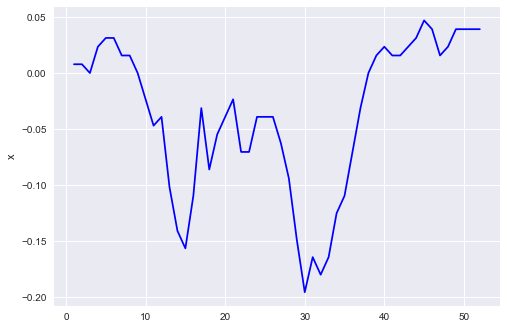

In [36]:
new_what_adam22 = get_signr_sess_test_data(new_what,"adam22")
new_what_john32 = get_signr_sess_test_data(new_what,"john32")
new_what_waleed11 = get_signr_sess_test_data(new_what,"waleed11")
new_what_waleed13 = get_signr_sess_test_data(new_what,"waleed13")
new_what_waleed24 = get_signr_sess_test_data(new_what,"waleed24")
new_what_waleed42 = get_signr_sess_test_data(new_what,"waleed42")

plt.plot(new_what_adam22.sign_index, new_what_adam22.x, 'b')
plt.ylabel('x')


In [ ]:

fig = plt.figure(figsize=(14,14))

ax1 = fig.add_subplot(431)
plt.plot(new_what_adam22.sign_index, new_what_adam22.x, 'b', \
         new_what_john32.sign_index, new_what_john32.x, 'g', \
         new_what_waleed11.sign_index, new_what_waleed11.x, 'r', \
         new_what_waleed13.sign_index, new_what_waleed13.x, 'c', \
         new_what_waleed24.sign_index, new_what_waleed24.x, 'm', \
         new_what_waleed42.sign_index, new_what_waleed42.x, 'y')
plt.ylabel('x')

ax2 = fig.add_subplot(432)
plt.plot(new_what_adam22.sign_index, new_what_adam22.y, 'b', \
         new_what_john32.sign_index, new_what_john32.y, 'g', \
         new_what_waleed11.sign_index, new_what_waleed11.y, 'r', \
         new_what_waleed13.sign_index, new_what_waleed13.y, 'c', \
         new_what_waleed24.sign_index, new_what_waleed24.y, 'm', \
         new_what_waleed42.sign_index, new_what_waleed42.y, 'y')
plt.ylabel('y')

ax3 = fig.add_subplot(433)
plt.plot(new_what_adam22.sign_index, new_what_adam22.z, 'b', \
         new_what_john32.sign_index, new_what_john32.z, 'g', \
         new_what_waleed11.sign_index, new_what_waleed11.z, 'r', \
         new_what_waleed13.sign_index, new_what_waleed13.z, 'c', \
         new_what_waleed24.sign_index, new_what_waleed24.z, 'm', \
         new_what_waleed42.sign_index, new_what_waleed42.z, 'y')
plt.ylabel('z')

ax4 = fig.add_subplot(434)
plt.plot(new_what_adam22.sign_index, new_what_adam22.roll, 'b', \
         new_what_john32.sign_index, new_what_john32.roll, 'g', \
         new_what_waleed11.sign_index, new_what_waleed11.roll, 'r', \
         new_what_waleed13.sign_index, new_what_waleed13.roll, 'c', \
         new_what_waleed24.sign_index, new_what_waleed24.roll, 'm', \
         new_what_waleed42.sign_index, new_what_waleed42.roll, 'y')
plt.ylabel('roll')

ax5 = fig.add_subplot(435)
plt.plot(new_what_adam22.sign_index, new_what_adam22.pitch, 'b', \
         new_what_john32.sign_index, new_what_john32.pitch, 'g', \
         new_what_waleed11.sign_index, new_what_waleed11.pitch, 'r', \
         new_what_waleed13.sign_index, new_what_waleed13.pitch, 'c', \
         new_what_waleed24.sign_index, new_what_waleed24.pitch, 'm', \
         new_what_waleed42.sign_index, new_what_waleed42.pitch, 'y')
plt.ylabel('pitch')

ax6 = fig.add_subplot(436)
plt.plot(new_what_adam22.sign_index, new_what_adam22.yaw, 'b', \
         new_what_john32.sign_index, new_what_john32.yaw, 'g', \
         new_what_waleed11.sign_index, new_what_waleed11.yaw, 'r', \
         new_what_waleed13.sign_index, new_what_waleed13.yaw, 'c', \
         new_what_waleed24.sign_index, new_what_waleed24.yaw, 'm', \
         new_what_waleed42.sign_index, new_what_waleed42.yaw, 'y')
plt.ylabel('yaw')

ax7 = fig.add_subplot(437)
plt.plot(new_what_adam22.sign_index, new_what_adam22.thumb_bend, 'b', \
         new_what_john32.sign_index, new_what_john32.thumb_bend, 'g', \
         new_what_waleed11.sign_index, new_what_waleed11.thumb_bend, 'r', \
         new_what_waleed13.sign_index, new_what_waleed13.thumb_bend, 'c', \
         new_what_waleed24.sign_index, new_what_waleed24.thumb_bend, 'm', \
         new_what_waleed42.sign_index, new_what_waleed42.thumb_bend, 'y')
plt.ylabel('thumb_bend')

ax8 = fig.add_subplot(438)
plt.plot(new_what_adam22.sign_index, new_what_adam22.pointer_bend, 'b', \
         new_what_john32.sign_index, new_what_john32.pointer_bend, 'g', \
         new_what_waleed11.sign_index, new_what_waleed11.pointer_bend, 'r', \
         new_what_waleed13.sign_index, new_what_waleed13.pointer_bend, 'c', \
         new_what_waleed24.sign_index, new_what_waleed24.pointer_bend, 'm', \
         new_what_waleed42.sign_index, new_what_waleed42.pointer_bend, 'y')
plt.ylabel('pointer_bend')

ax9 = fig.add_subplot(439)
plt.plot(new_what_adam22.sign_index, new_what_adam22.middle_bend, 'b', \
         new_what_john32.sign_index, new_what_john32.middle_bend, 'g', \
         new_what_waleed11.sign_index, new_what_waleed11.middle_bend, 'r', \
         new_what_waleed13.sign_index, new_what_waleed13.middle_bend, 'c', \
         new_what_waleed24.sign_index, new_what_waleed24.middle_bend, 'm', \
         new_what_waleed42.sign_index, new_what_waleed42.middle_bend, 'y')
plt.ylabel('middle_bend')

ax10 = fig.add_subplot(4,3,10)
plt.plot(new_what_adam22.sign_index, new_what_adam22.ring_bend, 'b', \
         new_what_john32.sign_index, new_what_john32.ring_bend, 'g', \
         new_what_waleed11.sign_index, new_what_waleed11.ring_bend, 'r', \
         new_what_waleed13.sign_index, new_what_waleed13.ring_bend, 'c', \
         new_what_waleed24.sign_index, new_what_waleed24.ring_bend, 'm', \
         new_what_waleed42.sign_index, new_what_waleed42.ring_bend, 'y')
plt.ylabel('ring_bend')

ax11 = fig.add_subplot(4,3,11)
plt.plot(new_what_adam22.sign_index, new_what_adam22.pinky_bend, 'b', \
         new_what_john32.sign_index, new_what_john32.pinky_bend, 'g', \
         new_what_waleed11.sign_index, new_what_waleed11.pinky_bend, 'r', \
         new_what_waleed13.sign_index, new_what_waleed13.pinky_bend, 'c', \
         new_what_waleed24.sign_index, new_what_waleed24.pinky_bend, 'm', \
         new_what_waleed42.sign_index, new_what_waleed42.pinky_bend, 'y')
plt.ylabel('pinky_bend')

## When Data Plots

In [ ]:
new_when.signr_sess_test.unique()

In [ ]:
new_when_john33 = get_signr_sess_test_data(new_when,"john33")
new_when_stephen42 = get_signr_sess_test_data(new_when,"stephen42")
new_when_waleed14 = get_signr_sess_test_data(new_when,"waleed14")
new_when_waleed20 = get_signr_sess_test_data(new_when,"waleed20")
new_when_waleed22 = get_signr_sess_test_data(new_when,"waleed22")

fig = plt.figure(figsize=(14,14))

ax1 = fig.add_subplot(431)
plt.plot(new_when_john33.sign_index, new_when_john33.x, 'b', \
         new_when_stephen42.sign_index, new_when_stephen42.x, 'g', \
         new_when_waleed14.sign_index, new_when_waleed14.x, 'r', \
         new_when_waleed20.sign_index, new_when_waleed20.x, 'c', \
         new_when_waleed22.sign_index, new_when_waleed22.x, 'm')
plt.ylabel('x')

ax2 = fig.add_subplot(432)
plt.plot(new_when_john33.sign_index, new_when_john33.y, 'b', \
         new_when_stephen42.sign_index, new_when_stephen42.y, 'g', \
         new_when_waleed14.sign_index, new_when_waleed14.y, 'r', \
         new_when_waleed20.sign_index, new_when_waleed20.y, 'c', \
         new_when_waleed22.sign_index, new_when_waleed22.y, 'm')
plt.ylabel('y')

ax3 = fig.add_subplot(433)
plt.plot(new_when_john33.sign_index, new_when_john33.z, 'b', \
         new_when_stephen42.sign_index, new_when_stephen42.z, 'g', \
         new_when_waleed14.sign_index, new_when_waleed14.z, 'r', \
         new_when_waleed20.sign_index, new_when_waleed20.z, 'c', \
         new_when_waleed22.sign_index, new_when_waleed22.z, 'm')
plt.ylabel('z')

ax4 = fig.add_subplot(434)
plt.plot(new_when_john33.sign_index, new_when_john33.roll, 'b', \
         new_when_stephen42.sign_index, new_when_stephen42.roll, 'g', \
         new_when_waleed14.sign_index, new_when_waleed14.roll, 'r', \
         new_when_waleed20.sign_index, new_when_waleed20.roll, 'c', \
         new_when_waleed22.sign_index, new_when_waleed22.roll, 'm')
plt.ylabel('roll')

ax5 = fig.add_subplot(435)
plt.plot(new_when_john33.sign_index, new_when_john33.pitch, 'b', \
         new_when_stephen42.sign_index, new_when_stephen42.pitch, 'g', \
         new_when_waleed14.sign_index, new_when_waleed14.pitch, 'r', \
         new_when_waleed20.sign_index, new_when_waleed20.pitch, 'c', \
         new_when_waleed22.sign_index, new_when_waleed22.pitch, 'm')
plt.ylabel('pitch')

ax6 = fig.add_subplot(436)
plt.plot(new_when_john33.sign_index, new_when_john33.yaw, 'b', \
         new_when_stephen42.sign_index, new_when_stephen42.yaw, 'g', \
         new_when_waleed14.sign_index, new_when_waleed14.yaw, 'r', \
         new_when_waleed20.sign_index, new_when_waleed20.yaw, 'c', \
         new_when_waleed22.sign_index, new_when_waleed22.yaw, 'm')
plt.ylabel('yaw')


ax7 = fig.add_subplot(437)
plt.plot(new_when_john33.sign_index, new_when_john33.thumb_bend, 'b', \
         new_when_stephen42.sign_index, new_when_stephen42.thumb_bend, 'g', \
         new_when_waleed14.sign_index, new_when_waleed14.thumb_bend, 'r', \
         new_when_waleed20.sign_index, new_when_waleed20.thumb_bend, 'c', \
         new_when_waleed22.sign_index, new_when_waleed22.thumb_bend, 'm')
plt.ylabel('thumb_bend')

ax8 = fig.add_subplot(438)
plt.plot(new_when_john33.sign_index, new_when_john33.pointer_bend, 'b', \
         new_when_stephen42.sign_index, new_when_stephen42.pointer_bend, 'g', \
         new_when_waleed14.sign_index, new_when_waleed14.pointer_bend, 'r', \
         new_when_waleed20.sign_index, new_when_waleed20.pointer_bend, 'c', \
         new_when_waleed22.sign_index, new_when_waleed22.pointer_bend, 'm')
plt.ylabel('pointer_bend')

ax9 = fig.add_subplot(439)
plt.plot(new_when_john33.sign_index, new_when_john33.middle_bend, 'b', \
         new_when_stephen42.sign_index, new_when_stephen42.middle_bend, 'g', \
         new_when_waleed14.sign_index, new_when_waleed14.middle_bend, 'r', \
         new_when_waleed20.sign_index, new_when_waleed20.middle_bend, 'c', \
         new_when_waleed22.sign_index, new_when_waleed22.middle_bend, 'm')
plt.ylabel('middle_bend')

ax10 = fig.add_subplot(4,3,10)
plt.plot(new_when_john33.sign_index, new_when_john33.ring_bend, 'b', \
         new_when_stephen42.sign_index, new_when_stephen42.ring_bend, 'g', \
         new_when_waleed14.sign_index, new_when_waleed14.ring_bend, 'r', \
         new_when_waleed20.sign_index, new_when_waleed20.ring_bend, 'c', \
         new_when_waleed22.sign_index, new_when_waleed22.ring_bend, 'm')
plt.ylabel('ring_bend')

ax11 = fig.add_subplot(4,3,11)
plt.plot(new_when_john33.sign_index, new_when_john33.pinky_bend, 'b', \
         new_when_stephen42.sign_index, new_when_stephen42.pinky_bend, 'g', \
         new_when_waleed14.sign_index, new_when_waleed14.pinky_bend, 'r', \
         new_when_waleed20.sign_index, new_when_waleed20.pinky_bend, 'c', \
         new_when_waleed22.sign_index, new_when_waleed22.pinky_bend, 'm')
plt.ylabel('pinky_bend')

## Where Data Plots

In [ ]:
new_where.signr_sess_test.unique()

In [ ]:
new_where_adam24 = get_signr_sess_test_data(new_where,"adam24")
new_where_john34 = get_signr_sess_test_data(new_where,"john34")
new_where_john40 = get_signr_sess_test_data(new_where,"john40")
new_where_waleed11 = get_signr_sess_test_data(new_where,"waleed11")
new_where_waleed13 = get_signr_sess_test_data(new_where,"waleed13")
new_where_waleed23 = get_signr_sess_test_data(new_where,"waleed23")
new_where_waleed44 = get_signr_sess_test_data(new_where,"waleed44")

fig = plt.figure(figsize=(14,14))

ax1 = fig.add_subplot(431)
plt.plot(new_where_adam24.sign_index, new_where_adam24.x, 'b', \
         new_where_john34.sign_index, new_where_john34.x, 'g', \
         new_where_john40.sign_index, new_where_john40.x, 'r', \
         new_where_waleed11.sign_index, new_where_waleed11.x, 'c', \
         new_where_waleed13.sign_index, new_where_waleed13.x, 'm', \
         new_where_waleed23.sign_index, new_where_waleed23.x, 'y', \
         new_where_waleed44.sign_index, new_where_waleed44.x, 'k')
plt.ylabel('x')

ax2 = fig.add_subplot(432)
plt.plot(new_where_adam24.sign_index, new_where_adam24.y, 'b', \
         new_where_john34.sign_index, new_where_john34.y, 'g', \
         new_where_john40.sign_index, new_where_john40.y, 'r', \
         new_where_waleed11.sign_index, new_where_waleed11.y, 'c', \
         new_where_waleed13.sign_index, new_where_waleed13.y, 'm', \
         new_where_waleed23.sign_index, new_where_waleed23.y, 'y', \
         new_where_waleed44.sign_index, new_where_waleed44.y, 'k')
plt.ylabel('y')

ax3 = fig.add_subplot(433)
plt.plot(new_where_adam24.sign_index, new_where_adam24.z, 'b', \
         new_where_john34.sign_index, new_where_john34.z, 'g', \
         new_where_john40.sign_index, new_where_john40.z, 'r', \
         new_where_waleed11.sign_index, new_where_waleed11.z, 'c', \
         new_where_waleed13.sign_index, new_where_waleed13.z, 'm', \
         new_where_waleed23.sign_index, new_where_waleed23.z, 'y', \
         new_where_waleed44.sign_index, new_where_waleed44.z, 'k')
plt.ylabel('z')

ax4 = fig.add_subplot(434)
plt.plot(new_where_adam24.sign_index, new_where_adam24.roll, 'b', \
         new_where_john34.sign_index, new_where_john34.roll, 'g', \
         new_where_john40.sign_index, new_where_john40.roll, 'r', \
         new_where_waleed11.sign_index, new_where_waleed11.roll, 'c', \
         new_where_waleed13.sign_index, new_where_waleed13.roll, 'm', \
         new_where_waleed23.sign_index, new_where_waleed23.roll, 'y', \
         new_where_waleed44.sign_index, new_where_waleed44.roll, 'k')
plt.ylabel('roll')

ax5 = fig.add_subplot(435)
plt.plot(new_where_adam24.sign_index, new_where_adam24.pitch, 'b', \
         new_where_john34.sign_index, new_where_john34.pitch, 'g', \
         new_where_john40.sign_index, new_where_john40.pitch, 'r', \
         new_where_waleed11.sign_index, new_where_waleed11.pitch, 'c', \
         new_where_waleed13.sign_index, new_where_waleed13.pitch, 'm', \
         new_where_waleed23.sign_index, new_where_waleed23.pitch, 'y', \
         new_where_waleed44.sign_index, new_where_waleed44.pitch, 'k')
plt.ylabel('pitch')

ax6 = fig.add_subplot(436)
plt.plot(new_where_adam24.sign_index, new_where_adam24.yaw, 'b', \
         new_where_john34.sign_index, new_where_john34.yaw, 'g', \
         new_where_john40.sign_index, new_where_john40.yaw, 'r', \
         new_where_waleed11.sign_index, new_where_waleed11.yaw, 'c', \
         new_where_waleed13.sign_index, new_where_waleed13.yaw, 'm', \
         new_where_waleed23.sign_index, new_where_waleed23.yaw, 'y', \
         new_where_waleed44.sign_index, new_where_waleed44.yaw, 'k')
plt.ylabel('yaw')

ax7 = fig.add_subplot(437)
plt.plot(new_where_adam24.sign_index, new_where_adam24.thumb_bend, 'b', \
         new_where_john34.sign_index, new_where_john34.thumb_bend, 'g', \
         new_where_john40.sign_index, new_where_john40.thumb_bend, 'r', \
         new_where_waleed11.sign_index, new_where_waleed11.thumb_bend, 'c', \
         new_where_waleed13.sign_index, new_where_waleed13.thumb_bend, 'm', \
         new_where_waleed23.sign_index, new_where_waleed23.thumb_bend, 'y', \
         new_where_waleed44.sign_index, new_where_waleed44.thumb_bend, 'k')
plt.ylabel('thumb_bend')

ax8 = fig.add_subplot(438)
plt.plot(new_where_adam24.sign_index, new_where_adam24.pointer_bend, 'b', \
         new_where_john34.sign_index, new_where_john34.pointer_bend, 'g', \
         new_where_john40.sign_index, new_where_john40.pointer_bend, 'r', \
         new_where_waleed11.sign_index, new_where_waleed11.pointer_bend, 'c', \
         new_where_waleed13.sign_index, new_where_waleed13.pointer_bend, 'm', \
         new_where_waleed23.sign_index, new_where_waleed23.pointer_bend, 'y', \
         new_where_waleed44.sign_index, new_where_waleed44.pointer_bend, 'k')
plt.ylabel('pointer_bend')

ax9 = fig.add_subplot(439)
plt.plot(new_where_adam24.sign_index, new_where_adam24.middle_bend, 'b', \
         new_where_john34.sign_index, new_where_john34.middle_bend, 'g', \
         new_where_john40.sign_index, new_where_john40.middle_bend, 'r', \
         new_where_waleed11.sign_index, new_where_waleed11.middle_bend, 'c', \
         new_where_waleed13.sign_index, new_where_waleed13.middle_bend, 'm', \
         new_where_waleed23.sign_index, new_where_waleed23.middle_bend, 'y', \
         new_where_waleed44.sign_index, new_where_waleed44.middle_bend, 'k')
plt.ylabel('middle_bend')

ax10 = fig.add_subplot(4,3,10)
plt.plot(new_where_adam24.sign_index, new_where_adam24.ring_bend, 'b', \
         new_where_john34.sign_index, new_where_john34.ring_bend, 'g', \
         new_where_john40.sign_index, new_where_john40.ring_bend, 'r', \
         new_where_waleed11.sign_index, new_where_waleed11.ring_bend, 'c', \
         new_where_waleed13.sign_index, new_where_waleed13.ring_bend, 'm', \
         new_where_waleed23.sign_index, new_where_waleed23.ring_bend, 'y', \
         new_where_waleed44.sign_index, new_where_waleed44.ring_bend, 'k')
plt.ylabel('ring_bend')

ax11 = fig.add_subplot(4,3,11)
plt.plot(new_where_adam24.sign_index, new_where_adam24.pinky_bend, 'b', \
         new_where_john34.sign_index, new_where_john34.pinky_bend, 'g', \
         new_where_john40.sign_index, new_where_john40.pinky_bend, 'r', \
         new_where_waleed11.sign_index, new_where_waleed11.pinky_bend, 'c', \
         new_where_waleed13.sign_index, new_where_waleed13.pinky_bend, 'm', \
         new_where_waleed23.sign_index, new_where_waleed23.pinky_bend, 'y', \
         new_where_waleed44.sign_index, new_where_waleed44.pinky_bend, 'k')
plt.ylabel('pinky_bend')

## Which Data Plots

In [ ]:
new_which.signr_sess_test.unique()

In [ ]:
new_which_adam11 = get_signr_sess_test_data(new_which,"adam11")
new_which_andrew23 = get_signr_sess_test_data(new_which,"andrew23")
new_which_john30 = get_signr_sess_test_data(new_which,"john30")
new_which_john32 = get_signr_sess_test_data(new_which,"john32")
new_which_john33 = get_signr_sess_test_data(new_which,"john33")
new_which_waleed21 = get_signr_sess_test_data(new_which,"waleed21")
new_which_waleed40 = get_signr_sess_test_data(new_which,"waleed40")
new_which_waleed43 = get_signr_sess_test_data(new_which,"waleed43")

fig = plt.figure(figsize=(14,14))

ax1 = fig.add_subplot(431)
plt.plot(new_which_adam11.sign_index, new_which_adam11.x, 'b', \
         new_which_andrew23.sign_index, new_which_andrew23.x, 'g', \
         new_which_john30.sign_index, new_which_john30.x, 'r', \
         new_which_john32.sign_index, new_which_john32.x, 'c', \
         new_which_john33.sign_index, new_which_john33.x, 'm', \
         new_which_waleed21.sign_index, new_which_waleed21.x, 'y', \
         new_which_waleed40.sign_index, new_which_waleed40.x, 'k', \
         new_which_waleed43.sign_index, new_which_waleed43.x, 'b:')
plt.ylabel('x')

ax2 = fig.add_subplot(432)
plt.plot(new_which_adam11.sign_index, new_which_adam11.y, 'b', \
         new_which_andrew23.sign_index, new_which_andrew23.y, 'g', \
         new_which_john30.sign_index, new_which_john30.y, 'r', \
         new_which_john32.sign_index, new_which_john32.y, 'c', \
         new_which_john33.sign_index, new_which_john33.y, 'm', \
         new_which_waleed21.sign_index, new_which_waleed21.y, 'y', \
         new_which_waleed40.sign_index, new_which_waleed40.y, 'k', \
         new_which_waleed43.sign_index, new_which_waleed43.y, 'b:')
plt.ylabel('y')

ax3 = fig.add_subplot(433)
plt.plot(new_which_adam11.sign_index, new_which_adam11.z, 'b', \
         new_which_andrew23.sign_index, new_which_andrew23.z, 'g', \
         new_which_john30.sign_index, new_which_john30.z, 'r', \
         new_which_john32.sign_index, new_which_john32.z, 'c', \
         new_which_john33.sign_index, new_which_john33.z, 'm', \
         new_which_waleed21.sign_index, new_which_waleed21.z, 'y', \
         new_which_waleed40.sign_index, new_which_waleed40.z, 'k', \
         new_which_waleed43.sign_index, new_which_waleed43.z, 'b:')
plt.ylabel('z')

ax4 = fig.add_subplot(434)
plt.plot(new_which_adam11.sign_index, new_which_adam11.roll, 'b', \
         new_which_andrew23.sign_index, new_which_andrew23.roll, 'g', \
         new_which_john30.sign_index, new_which_john30.roll, 'r', \
         new_which_john32.sign_index, new_which_john32.roll, 'c', \
         new_which_john33.sign_index, new_which_john33.roll, 'm', \
         new_which_waleed21.sign_index, new_which_waleed21.roll, 'y', \
         new_which_waleed40.sign_index, new_which_waleed40.roll, 'k', \
         new_which_waleed43.sign_index, new_which_waleed43.roll, 'b:')
plt.ylabel('roll')

ax5 = fig.add_subplot(435)
plt.plot(new_which_adam11.sign_index, new_which_adam11.pitch, 'b', \
         new_which_andrew23.sign_index, new_which_andrew23.pitch, 'g', \
         new_which_john30.sign_index, new_which_john30.pitch, 'r', \
         new_which_john32.sign_index, new_which_john32.pitch, 'c', \
         new_which_john33.sign_index, new_which_john33.pitch, 'm', \
         new_which_waleed21.sign_index, new_which_waleed21.pitch, 'y', \
         new_which_waleed40.sign_index, new_which_waleed40.pitch, 'k', \
         new_which_waleed43.sign_index, new_which_waleed43.pitch, 'b:')
plt.ylabel('pitch')

ax6 = fig.add_subplot(436)
plt.plot(new_which_adam11.sign_index, new_which_adam11.yaw, 'b', \
         new_which_andrew23.sign_index, new_which_andrew23.yaw, 'g', \
         new_which_john30.sign_index, new_which_john30.yaw, 'r', \
         new_which_john32.sign_index, new_which_john32.yaw, 'c', \
         new_which_john33.sign_index, new_which_john33.yaw, 'm', \
         new_which_waleed21.sign_index, new_which_waleed21.yaw, 'y', \
         new_which_waleed40.sign_index, new_which_waleed40.yaw, 'k', \
         new_which_waleed43.sign_index, new_which_waleed43.yaw, 'b:')
plt.ylabel('yaw')

ax7 = fig.add_subplot(437)
plt.plot(new_which_adam11.sign_index, new_which_adam11.thumb_bend, 'b', \
         new_which_andrew23.sign_index, new_which_andrew23.thumb_bend, 'g', \
         new_which_john30.sign_index, new_which_john30.thumb_bend, 'r', \
         new_which_john32.sign_index, new_which_john32.thumb_bend, 'c', \
         new_which_john33.sign_index, new_which_john33.thumb_bend, 'm', \
         new_which_waleed21.sign_index, new_which_waleed21.thumb_bend, 'y', \
         new_which_waleed40.sign_index, new_which_waleed40.thumb_bend, 'k', \
         new_which_waleed43.sign_index, new_which_waleed43.thumb_bend, 'b:')
plt.ylabel('thumb_bend')

ax8 = fig.add_subplot(438)
plt.plot(new_which_adam11.sign_index, new_which_adam11.pointer_bend, 'b', \
         new_which_andrew23.sign_index, new_which_andrew23.pointer_bend, 'g', \
         new_which_john30.sign_index, new_which_john30.pointer_bend, 'r', \
         new_which_john32.sign_index, new_which_john32.pointer_bend, 'c', \
         new_which_john33.sign_index, new_which_john33.pointer_bend, 'm', \
         new_which_waleed21.sign_index, new_which_waleed21.pointer_bend, 'y', \
         new_which_waleed40.sign_index, new_which_waleed40.pointer_bend, 'k', \
         new_which_waleed43.sign_index, new_which_waleed43.pointer_bend, 'b:')
plt.ylabel('pointer_bend')

ax9 = fig.add_subplot(439)
plt.plot(new_which_adam11.sign_index, new_which_adam11.middle_bend, 'b', \
         new_which_andrew23.sign_index, new_which_andrew23.middle_bend, 'g', \
         new_which_john30.sign_index, new_which_john30.middle_bend, 'r', \
         new_which_john32.sign_index, new_which_john32.middle_bend, 'c', \
         new_which_john33.sign_index, new_which_john33.middle_bend, 'm', \
         new_which_waleed21.sign_index, new_which_waleed21.middle_bend, 'y', \
         new_which_waleed40.sign_index, new_which_waleed40.middle_bend, 'k', \
         new_which_waleed43.sign_index, new_which_waleed43.middle_bend, 'b:')
plt.ylabel('middle_bend')

ax10 = fig.add_subplot(4,3, 10)
plt.plot(new_which_adam11.sign_index, new_which_adam11.ring_bend, 'b', \
         new_which_andrew23.sign_index, new_which_andrew23.ring_bend, 'g', \
         new_which_john30.sign_index, new_which_john30.ring_bend, 'r', \
         new_which_john32.sign_index, new_which_john32.ring_bend, 'c', \
         new_which_john33.sign_index, new_which_john33.ring_bend, 'm', \
         new_which_waleed21.sign_index, new_which_waleed21.ring_bend, 'y', \
         new_which_waleed40.sign_index, new_which_waleed40.ring_bend, 'k', \
         new_which_waleed43.sign_index, new_which_waleed43.ring_bend, 'b:')
plt.ylabel('ring_bend')

ax11 = fig.add_subplot(4,3,11)
plt.plot(new_which_adam11.sign_index, new_which_adam11.pinky_bend, 'b', \
         new_which_andrew23.sign_index, new_which_andrew23.pinky_bend, 'g', \
         new_which_john30.sign_index, new_which_john30.pinky_bend, 'r', \
         new_which_john32.sign_index, new_which_john32.pinky_bend, 'c', \
         new_which_john33.sign_index, new_which_john33.pinky_bend, 'm', \
         new_which_waleed21.sign_index, new_which_waleed21.pinky_bend, 'y', \
         new_which_waleed40.sign_index, new_which_waleed40.pinky_bend, 'k', \
         new_which_waleed43.sign_index, new_which_waleed43.pinky_bend, 'b:')
plt.ylabel('pinky_bend')

## Who Data Plots

In [ ]:
new_who.signr_sess_test.unique()

In [ ]:
new_who_adam24 = get_signr_sess_test_data(new_who,"adam24")
new_who_adam25 = get_signr_sess_test_data(new_who,"adam25")
new_who_waleed10 = get_signr_sess_test_data(new_who,"waleed10")
new_who_waleed14 = get_signr_sess_test_data(new_who,"waleed14")
new_who_waleed43 = get_signr_sess_test_data(new_who,"waleed43")

fig = plt.figure(figsize=(14,14))

ax1 = fig.add_subplot(431)
plt.plot(new_who_adam24.sign_index, new_who_adam24.x, 'b', \
         new_who_adam25.sign_index, new_who_adam25.x, 'g', \
         new_who_waleed10.sign_index, new_who_waleed10.x, 'r', \
         new_who_waleed14.sign_index, new_who_waleed14.x, 'c', \
         new_who_waleed43.sign_index, new_who_waleed43.x, 'm')
plt.ylabel('x')

ax2 = fig.add_subplot(432)
plt.plot(new_who_adam24.sign_index, new_who_adam24.y, 'b', \
         new_who_adam25.sign_index, new_who_adam25.y, 'g', \
         new_who_waleed10.sign_index, new_who_waleed10.y, 'r', \
         new_who_waleed14.sign_index, new_who_waleed14.y, 'c', \
         new_who_waleed43.sign_index, new_who_waleed43.y, 'm')
plt.ylabel('y')

ax3 = fig.add_subplot(433)
plt.plot(new_who_adam24.sign_index, new_who_adam24.z, 'b', \
         new_who_adam25.sign_index, new_who_adam25.z, 'g', \
         new_who_waleed10.sign_index, new_who_waleed10.z, 'r', \
         new_who_waleed14.sign_index, new_who_waleed14.z, 'c', \
         new_who_waleed43.sign_index, new_who_waleed43.z, 'm')
plt.ylabel('z')

ax4 = fig.add_subplot(434)
plt.plot(new_who_adam24.sign_index, new_who_adam24.roll, 'b', \
         new_who_adam25.sign_index, new_who_adam25.roll, 'g', \
         new_who_waleed10.sign_index, new_who_waleed10.roll, 'r', \
         new_who_waleed14.sign_index, new_who_waleed14.roll, 'c', \
         new_who_waleed43.sign_index, new_who_waleed43.roll, 'm')
plt.ylabel('roll')

ax5 = fig.add_subplot(435)
plt.plot(new_who_adam24.sign_index, new_who_adam24.pitch, 'b', \
         new_who_adam25.sign_index, new_who_adam25.pitch, 'g', \
         new_who_waleed10.sign_index, new_who_waleed10.pitch, 'r', \
         new_who_waleed14.sign_index, new_who_waleed14.pitch, 'c', \
         new_who_waleed43.sign_index, new_who_waleed43.pitch, 'm')
plt.ylabel('pitch')

ax6 = fig.add_subplot(436)
plt.plot(new_who_adam24.sign_index, new_who_adam24.yaw, 'b', \
         new_who_adam25.sign_index, new_who_adam25.yaw, 'g', \
         new_who_waleed10.sign_index, new_who_waleed10.yaw, 'r', \
         new_who_waleed14.sign_index, new_who_waleed14.yaw, 'c', \
         new_who_waleed43.sign_index, new_who_waleed43.yaw, 'm')
plt.ylabel('yaw')

ax7 = fig.add_subplot(437)
plt.plot(new_who_adam24.sign_index, new_who_adam24.thumb_bend, 'b', \
         new_who_adam25.sign_index, new_who_adam25.thumb_bend, 'g', \
         new_who_waleed10.sign_index, new_who_waleed10.thumb_bend, 'r', \
         new_who_waleed14.sign_index, new_who_waleed14.thumb_bend, 'c', \
         new_who_waleed43.sign_index, new_who_waleed43.thumb_bend, 'm')
plt.ylabel('thumb_bend')

ax8 = fig.add_subplot(438)
plt.plot(new_who_adam24.sign_index, new_who_adam24.pointer_bend, 'b', \
         new_who_adam25.sign_index, new_who_adam25.pointer_bend, 'g', \
         new_who_waleed10.sign_index, new_who_waleed10.pointer_bend, 'r', \
         new_who_waleed14.sign_index, new_who_waleed14.pointer_bend, 'c', \
         new_who_waleed43.sign_index, new_who_waleed43.pointer_bend, 'm')
plt.ylabel('pointer_bend')

ax9 = fig.add_subplot(439)
plt.plot(new_who_adam24.sign_index, new_who_adam24.middle_bend, 'b', \
         new_who_adam25.sign_index, new_who_adam25.middle_bend, 'g', \
         new_who_waleed10.sign_index, new_who_waleed10.middle_bend, 'r', \
         new_who_waleed14.sign_index, new_who_waleed14.middle_bend, 'c', \
         new_who_waleed43.sign_index, new_who_waleed43.middle_bend, 'm')
plt.ylabel('middle_bend')

ax10 = fig.add_subplot(4,3,10)
plt.plot(new_who_adam24.sign_index, new_who_adam24.ring_bend, 'b', \
         new_who_adam25.sign_index, new_who_adam25.ring_bend, 'g', \
         new_who_waleed10.sign_index, new_who_waleed10.ring_bend, 'r', \
         new_who_waleed14.sign_index, new_who_waleed14.ring_bend, 'c', \
         new_who_waleed43.sign_index, new_who_waleed43.ring_bend, 'm')
plt.ylabel('ring_bend')

ax11 = fig.add_subplot(4,3,11)
plt.plot(new_who_adam24.sign_index, new_who_adam24.pinky_bend, 'b', \
         new_who_adam25.sign_index, new_who_adam25.pinky_bend, 'g', \
         new_who_waleed10.sign_index, new_who_waleed10.pinky_bend, 'r', \
         new_who_waleed14.sign_index, new_who_waleed14.pinky_bend, 'c', \
         new_who_waleed43.sign_index, new_who_waleed43.pinky_bend, 'm')
plt.ylabel('pinky_bend')

## Why Data Plots

In [ ]:
new_why.signr_sess_test.unique()

In [ ]:
new_why_adam10 = get_signr_sess_test_data(new_why,"adam10")
new_why_john32 = get_signr_sess_test_data(new_why,"john32")
new_why_john34 = get_signr_sess_test_data(new_why,"john34")
new_why_john40 = get_signr_sess_test_data(new_why,"john40")
new_why_john41 = get_signr_sess_test_data(new_why,"john41")
new_why_john43 = get_signr_sess_test_data(new_why,"john43")
new_why_stephen21 = get_signr_sess_test_data(new_why,"stephen21")
new_why_waleed10 = get_signr_sess_test_data(new_why,"waleed10")
new_why_waleed22 = get_signr_sess_test_data(new_why,"waleed22")
new_why_waleed30 = get_signr_sess_test_data(new_why,"waleed30")

fig = plt.figure(figsize=(14,14))

ax1 = fig.add_subplot(431)
plt.plot(new_why_adam10.sign_index, new_why_adam10.x, 'b', \
         new_why_john32.sign_index, new_why_john32.x, 'g', \
         new_why_john34.sign_index, new_why_john34.x, 'r', \
         new_why_john40.sign_index, new_why_john40.x, 'c', \
         new_why_john41.sign_index, new_why_john41.x, 'm', \
         new_why_john43.sign_index, new_why_john43.x, 'y', \
         new_why_stephen21.sign_index, new_why_stephen21.x, 'k', \
         new_why_waleed10.sign_index, new_why_waleed10.x, 'b:', \
         new_why_waleed22.sign_index, new_why_waleed22.x, 'g:',  \
         new_why_waleed30.sign_index, new_why_waleed30.x, 'r:')
plt.ylabel('x')

ax2 = fig.add_subplot(432)
plt.plot(new_why_adam10.sign_index, new_why_adam10.y, 'b', \
         new_why_john32.sign_index, new_why_john32.y, 'g', \
         new_why_john34.sign_index, new_why_john34.y, 'r', \
         new_why_john40.sign_index, new_why_john40.y, 'c', \
         new_why_john41.sign_index, new_why_john41.y, 'm', \
         new_why_john43.sign_index, new_why_john43.y, 'y', \
         new_why_stephen21.sign_index, new_why_stephen21.y, 'k', \
         new_why_waleed10.sign_index, new_why_waleed10.y, 'b:', \
         new_why_waleed22.sign_index, new_why_waleed22.y, 'g:', \
         new_why_waleed30.sign_index, new_why_waleed30.y, 'r:')
plt.ylabel('y')

ax3 = fig.add_subplot(433)
plt.plot(new_why_adam10.sign_index, new_why_adam10.z, 'b', \
         new_why_john32.sign_index, new_why_john32.z, 'g', \
         new_why_john34.sign_index, new_why_john34.z, 'r', \
         new_why_john40.sign_index, new_why_john40.z, 'c', \
         new_why_john41.sign_index, new_why_john41.z, 'm', \
         new_why_john43.sign_index, new_why_john43.z, 'y', \
         new_why_stephen21.sign_index, new_why_stephen21.z, 'k', \
         new_why_waleed10.sign_index, new_why_waleed10.z, 'b:', \
         new_why_waleed22.sign_index, new_why_waleed22.z, 'g:', \
         new_why_waleed30.sign_index, new_why_waleed30.z, 'r:')
plt.ylabel('z')

ax4 = fig.add_subplot(434)
plt.plot(new_why_adam10.sign_index, new_why_adam10.roll, 'b', \
         new_why_john32.sign_index, new_why_john32.roll, 'g', \
         new_why_john34.sign_index, new_why_john34.roll, 'r', \
         new_why_john40.sign_index, new_why_john40.roll, 'c', \
         new_why_john41.sign_index, new_why_john41.roll, 'm', \
         new_why_john43.sign_index, new_why_john43.roll, 'y', \
         new_why_stephen21.sign_index, new_why_stephen21.roll, 'k', \
         new_why_waleed10.sign_index, new_why_waleed10.roll, 'b:', \
         new_why_waleed22.sign_index, new_why_waleed22.roll, 'g:', \
         new_why_waleed30.sign_index, new_why_waleed30.roll, 'r:')
plt.ylabel('roll')

ax5 = fig.add_subplot(435)
plt.plot(new_why_adam10.sign_index, new_why_adam10.pitch, 'b', \
         new_why_john32.sign_index, new_why_john32.pitch, 'g', \
         new_why_john34.sign_index, new_why_john34.pitch, 'r', \
         new_why_john40.sign_index, new_why_john40.pitch, 'c', \
         new_why_john41.sign_index, new_why_john41.pitch, 'm', \
         new_why_john43.sign_index, new_why_john43.pitch, 'y', \
         new_why_stephen21.sign_index, new_why_stephen21.pitch, 'k', \
         new_why_waleed10.sign_index, new_why_waleed10.pitch, 'b:', \
         new_why_waleed22.sign_index, new_why_waleed22.pitch, 'g:', \
         new_why_waleed30.sign_index, new_why_waleed30.pitch, 'r:')
plt.ylabel('pitch')

ax6 = fig.add_subplot(436)
plt.plot(new_why_adam10.sign_index, new_why_adam10.yaw, 'b', \
         new_why_john32.sign_index, new_why_john32.yaw, 'g', \
         new_why_john34.sign_index, new_why_john34.yaw, 'r', \
         new_why_john40.sign_index, new_why_john40.yaw, 'c', \
         new_why_john41.sign_index, new_why_john41.yaw, 'm', \
         new_why_john43.sign_index, new_why_john43.yaw, 'y', \
         new_why_stephen21.sign_index, new_why_stephen21.yaw, 'k', \
         new_why_waleed10.sign_index, new_why_waleed10.yaw, 'b:', \
         new_why_waleed22.sign_index, new_why_waleed22.yaw, 'g:', \
         new_why_waleed30.sign_index, new_why_waleed30.yaw, 'r:')
plt.ylabel('yaw')

ax7 = fig.add_subplot(437)
plt.plot(new_why_adam10.sign_index, new_why_adam10.thumb_bend, 'b', \
         new_why_john32.sign_index, new_why_john32.thumb_bend, 'g', \
         new_why_john34.sign_index, new_why_john34.thumb_bend, 'r', \
         new_why_john40.sign_index, new_why_john40.thumb_bend, 'c', \
         new_why_john41.sign_index, new_why_john41.thumb_bend, 'm', \
         new_why_john43.sign_index, new_why_john43.thumb_bend, 'y', \
         new_why_stephen21.sign_index, new_why_stephen21.thumb_bend, 'k', \
         new_why_waleed10.sign_index, new_why_waleed10.thumb_bend, 'b:', \
         new_why_waleed22.sign_index, new_why_waleed22.thumb_bend, 'g:', \
         new_why_waleed30.sign_index, new_why_waleed30.thumb_bend, 'r:')
plt.ylabel('thumb_bend')

ax8 = fig.add_subplot(438)
plt.plot(new_why_adam10.sign_index, new_why_adam10.pointer_bend, 'b', \
         new_why_john32.sign_index, new_why_john32.pointer_bend, 'g', \
         new_why_john34.sign_index, new_why_john34.pointer_bend, 'r', \
         new_why_john40.sign_index, new_why_john40.pointer_bend, 'c', \
         new_why_john41.sign_index, new_why_john41.pointer_bend, 'm', \
         new_why_john43.sign_index, new_why_john43.pointer_bend, 'y', \
         new_why_stephen21.sign_index, new_why_stephen21.pointer_bend, 'k', \
         new_why_waleed10.sign_index, new_why_waleed10.pointer_bend, 'b:', \
         new_why_waleed22.sign_index, new_why_waleed22.pointer_bend, 'g:', \
         new_why_waleed30.sign_index, new_why_waleed30.pointer_bend, 'r:')
plt.ylabel('pointer_bend')

ax9 = fig.add_subplot(439)
plt.plot(new_why_adam10.sign_index, new_why_adam10.middle_bend, 'b', \
         new_why_john32.sign_index, new_why_john32.middle_bend, 'g', \
         new_why_john34.sign_index, new_why_john34.middle_bend, 'r', \
         new_why_john40.sign_index, new_why_john40.middle_bend, 'c', \
         new_why_john41.sign_index, new_why_john41.middle_bend, 'm', \
         new_why_john43.sign_index, new_why_john43.middle_bend, 'y', \
         new_why_stephen21.sign_index, new_why_stephen21.middle_bend, 'k', \
         new_why_waleed10.sign_index, new_why_waleed10.middle_bend, 'b:', \
         new_why_waleed22.sign_index, new_why_waleed22.middle_bend, 'g:', \
         new_why_waleed30.sign_index, new_why_waleed30.middle_bend, 'r:')
plt.ylabel('middle_bend')

ax10 = fig.add_subplot(4,3,10)
plt.plot(new_why_adam10.sign_index, new_why_adam10.ring_bend, 'b', \
         new_why_john32.sign_index, new_why_john32.ring_bend, 'g', \
         new_why_john34.sign_index, new_why_john34.ring_bend, 'r', \
         new_why_john40.sign_index, new_why_john40.ring_bend, 'c', \
         new_why_john41.sign_index, new_why_john41.ring_bend, 'm', \
         new_why_john43.sign_index, new_why_john43.ring_bend, 'y', \
         new_why_stephen21.sign_index, new_why_stephen21.ring_bend, 'k', \
         new_why_waleed10.sign_index, new_why_waleed10.ring_bend, 'b:', \
         new_why_waleed22.sign_index, new_why_waleed22.ring_bend, 'g:', \
         new_why_waleed30.sign_index, new_why_waleed30.ring_bend, 'r:')
plt.ylabel('ring_bend')

ax11 = fig.add_subplot(4,3,11)
plt.plot(new_why_adam10.sign_index, new_why_adam10.pinky_bend, 'b', \
         new_why_john32.sign_index, new_why_john32.pinky_bend, 'g', \
         new_why_john34.sign_index, new_why_john34.pinky_bend, 'r', \
         new_why_john40.sign_index, new_why_john40.pinky_bend, 'c', \
         new_why_john41.sign_index, new_why_john41.pinky_bend, 'm', \
         new_why_john43.sign_index, new_why_john43.pinky_bend, 'y', \
         new_why_stephen21.sign_index, new_why_stephen21.pinky_bend, 'k', \
         new_why_waleed10.sign_index, new_why_waleed10.pinky_bend, 'b:', \
         new_why_waleed22.sign_index, new_why_waleed22.pinky_bend, 'g:', \
         new_why_waleed30.sign_index, new_why_waleed30.pinky_bend, 'r:')
plt.ylabel('pinky_bend')

plt.show()

In [ ]:
    # IGNORE THIS PART.  STILL TRYING TO MAKE THIS WORK
    
    # this function plots the what data. it doesn't work right now
# def plot_what_data(new_what_adam22, feature):
#     a = plt.plot(new_what_adam22.sign_index, new_what_adam22[feature], 'b', \
#          new_what_john32.sign_index, new_what_john32.feature, 'g', \
#          new_what_waleed11.sign_index, new_what_waleed11.feature, 'r', \
#          new_what_waleed13.sign_index, new_what_waleed13.feature, 'c', \
#          new_what_waleed24.sign_index, new_what_waleed24.feature, 'm', \
#          new_what_waleed42.sign_index, new_what_waleed42.feature, 'y')
#     return a

# def plot_what_data(db1, db2, db3, db4, db5, db6, feature):
#     a = plt.plot(db1[sign_index], db1[feature], 'b', \
#          db2[sign_index], db2[feature], 'g', \
#          db3[sign_index], db3[feature], 'r', \
#          db4[sign_index], db4[feature], 'c', \
#          db5[sign_index], db5[feature], 'm', \
#          db6[sign_index], db6[feature], 'y')
#     return a

# plot_what_data(new_what_adam22, new_what_john32, new_what_waleed11,new_what_waleed13, new_what_waleed24, new_what_waleed42, x)



# Define plotting function.  still working on this
def iplot_scatter(X_axis, Y_axis):
    new_what.plot(kind = 'scatter', x = X_axis, y = Y_axis, c = color, figsize = (16, 8))
    
Y_Widget = Select(
    options=new_what.columns.tolist(),
    description='Y_axis',
    height='142px',
    width='250px'
)

def update_iplot_scatter(**kwargs):
    X_axis = X_Widget.value
    Y_axis = Y_Widget.value
    iplot_scatter(X_axis, Y_axis)
    
color = df.Species.map({'Setosa': 'red', 'Versicolor': 'green', 'Virginica': 'blue'})    

interactive(update_iplot_scatter, X_axis = sign_index, Y_axis = Y_Widget)